In [1]:
import numpy as np
import pandas as pd
import pickle

from collections import defaultdict
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles, MakeScaffoldGeneric, GetScaffoldForMol
from pdbbind_metadata_processor import PDBBindMetadataProcessor
from chembl_connector import ChEMBLConnector

In [2]:
pmp = PDBBindMetadataProcessor()
cc = ChEMBLConnector()
pdbbind_table = pmp.get_master_dataframe(remove_peptide_ligands=False)
chembl_targets_df = cc.get_target_table()

In [3]:
smiles_df = pd.read_csv('data/smiles_df.csv')

In [4]:
included_pdb_ids = smiles_df[smiles_df['included']]['id'].unique()
included_table = pdbbind_table[pdbbind_table['PDB code'].isin(included_pdb_ids)]
included_table = included_table.merge(chembl_targets_df, left_on='Uniprot ID', right_on='accession')

In [5]:
lyase_table = included_table[included_table['level2'] == 'enzyme  lyase']

In [6]:
lyase_table['gene_symbol_lowercase'].unique()

array(['ca2', 'aroq', 'ispf', 'hemb', 'adcy10', 'pck1', 'amd1', 'ca1',
       'dapa', 'glo1', 'acmsd', 'ca12', 'ca4', 'luxs', 'ca9', 'ca13',
       'sgpl1', 'ca7', 'ltc4s', 'sdh1', 'odc1', 'ca14'], dtype=object)

In [7]:
all_lyase_names = np.sort(lyase_table['gene_symbol_lowercase'].unique())

In [8]:
def get_training_pdbs(split, iteration) :
    
    if split in ['random', 'scaffold'] :
        train_smiles_path = f'data/ligand_{split}_splits/train_smiles_{split}_split_{iteration}.txt'
        with open(train_smiles_path, 'r') as f :
            train_smiles = f.readlines()
            train_smiles = [s.strip() for s in train_smiles]
        train_pdbs = smiles_df[smiles_df['smiles'].isin(train_smiles)]['id'].unique()
        
    elif split in ['protein'] :
        train_pdbs_path = f'data/protein_similarity_splits/train_pdb_protein_similarity_split_{iteration}.txt'
        with open(train_pdbs_path, 'r') as f :
            train_pdbs = f.readlines()
            train_pdbs = [s.strip() for s in train_pdbs]
            
    return train_pdbs

In [9]:
def get_scaffold(mol, generic=False) :
    core = GetScaffoldForMol(mol)
    if generic :
        core = MakeScaffoldGeneric(mol=core)
    scaffold = Chem.MolToSmiles(core)
    return scaffold

In [10]:
def get_target_ligand_scaffolds(target_name) :
    target_pdbs = lyase_table[lyase_table['gene_symbol_lowercase'] == target_name]['PDB code'].unique()
    print('N unique pdbs : ', len(target_pdbs))
    target_smiles = smiles_df[(smiles_df['id'].isin(target_pdbs)) & (smiles_df['included'])]['smiles'].unique()
    print('N unique smiles : ', len(target_smiles))
    scaffolds = []
    for smiles in target_smiles :
        mol = Chem.MolFromSmiles(smiles)
        scaffold = GetScaffoldForMol(mol)
        scaffold_smiles = Chem.MolToSmiles(scaffold)
        scaffolds.append(scaffold_smiles)
    scaffolds = set(scaffolds)
    print('N unique scaffolds : ', len(scaffolds))
    return scaffolds

In [11]:
def get_pdbs_scaffolds(pdbs) :
    print('N unique pdbs : ', len(pdbs))
    target_smiles = smiles_df[(smiles_df['id'].isin(pdbs)) & (smiles_df['included'])]['smiles'].unique()
    print('N unique smiles : ', len(target_smiles))
    scaffolds = []
    for smiles in target_smiles :
        mol = Chem.MolFromSmiles(smiles)
        scaffold = GetScaffoldForMol(mol)
        scaffold_smiles = Chem.MolToSmiles(scaffold)
        scaffolds.append(scaffold_smiles)
    scaffolds = set(scaffolds)
    print('N unique scaffolds : ', len(scaffolds))
    return scaffolds

N unique pdbs :  420
N unique smiles :  364
N unique scaffolds :  185


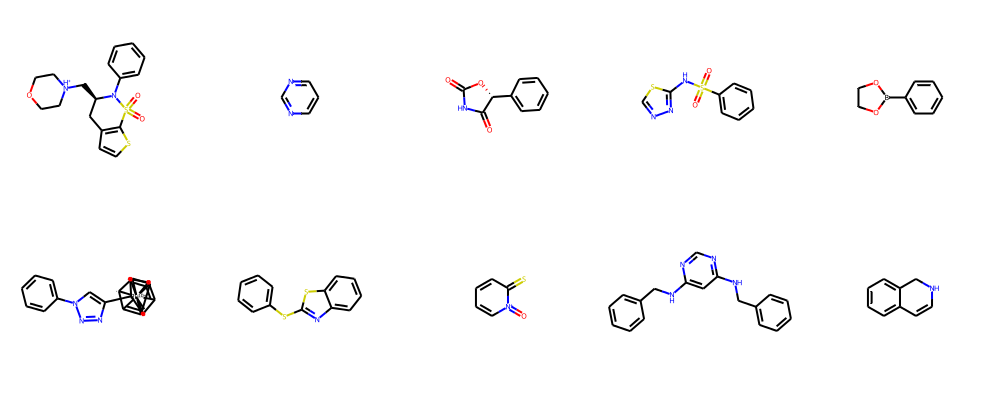

In [21]:
scaffolds = get_target_ligand_scaffolds('ca2')
mols = [Chem.MolFromSmiles(smiles) for smiles in scaffolds]
Draw.MolsToGridImage(mols[1:11], molsPerRow=5)

In [22]:
train_pdbs = get_training_pdbs('protein', 0)
train_scaffolds = get_pdbs_scaffolds(train_pdbs)
overlap_scaffolds = set(scaffolds).intersection(set(train_scaffolds))
len(overlap_scaffolds)

N unique pdbs :  13859
N unique smiles :  10154
N unique scaffolds :  6470


64

In [23]:
train_pdbs = get_training_pdbs('scaffold', 0)
train_scaffolds = get_pdbs_scaffolds(train_pdbs)
overlap_scaffolds = set(scaffolds).intersection(set(train_scaffolds))
len(overlap_scaffolds)

N unique pdbs :  13696
N unique smiles :  10139
N unique scaffolds :  6520


149

In [15]:
def get_results_for_pdbs(pdbs, mol_results) :
    
    all_results = {}
    ligand_smiles = smiles_df[smiles_df['id'].isin(pdbs)]['smiles'].unique()
    for smiles in ligand_smiles :
        if smiles in mol_results :
            all_results[smiles] = mol_results[smiles]
            
    target_results = defaultdict(list)
    for smiles, result in all_results.items() :
        if 'normalized_first_bioactive_rank' in result :
            for key in result.keys() :
                value = result[key]
                if type(value) in [int, float, np.float64] :
                    target_results[key].append(value)
            normalized_first_bioactive_rank_model = result['normalized_first_bioactive_rank']['model']
            target_results['normalized_first_bioactive_rank_model'].append(normalized_first_bioactive_rank_model)
    return target_results

In [16]:
def get_test_pdb_not_in_train_proteins(test_pdbs, train_target_names) :
    r = []
    for test_pdb in test_pdbs :
        target_names = get_lyase_names([test_pdb])
        if len(target_names) > 0 :
            target_name = target_names[0]
            if (target_name not in train_target_names) and (target_name in all_lyase_names) :
                r.append(test_pdb)
    return r

In [17]:
def get_test_pdb_also_in_train_proteins(test_pdbs, train_target_names) :
    r = []
    for test_pdb in test_pdbs :
        target_names = get_lyase_names([test_pdb])
        if len(target_names) > 0 :
            target_name = target_names[0]
            if (target_name in train_target_names) and (target_name in all_lyase_names) :
                r.append(test_pdb)
    return r

In [18]:
def get_results(split, iteration) :
    mol_results_path = f'results/{split}_split_{iteration}_pdbbind/mol_results.p'
    with open(mol_results_path, 'rb') as f :
        mol_results = pickle.load(f)
    return mol_results

def get_test_pdbs(split, iteration) :
    mol_results = get_results(split, iteration)
    test_pdbs = smiles_df[smiles_df['smiles'].isin(mol_results)]['id'].unique()
    return test_pdbs

def get_lyase_names(pdbs) :
    test_table = lyase_table[(lyase_table['PDB code'].isin(pdbs))]
    return test_table['gene_symbol_lowercase'].unique()

In [25]:
median_ranks = pd.DataFrame()
for split in ['random', 'scaffold', 'protein'] :
    for iteration in range(5) :
        print('Split: ', split)
        print('Iteration: ',iteration)
        train_pdbs = get_training_pdbs(split, iteration)
        train_target_names = get_lyase_names(train_pdbs)

        test_pdbs = get_test_pdbs(split, iteration)
        test_target_names = get_lyase_names(test_pdbs)

        in_train = [target for target in test_target_names if target in train_target_names]
        out_train = [target for target in test_target_names if target not in train_target_names]
        print('Test targets also in train: ', len(in_train))
        print(in_train)
        print('Test targets in test only: ',len(out_train))
        print(out_train)
        
        mol_results = get_results(split, iteration)
        
        test_pdbs_in_train = get_test_pdb_also_in_train_proteins(test_pdbs, train_target_names)
        test_results_also_in_train = get_results_for_pdbs(test_pdbs_in_train, mol_results)
        ranks = test_results_also_in_train['normalized_first_bioactive_rank_model']
        median_rank = np.median(ranks)
        print('N = ', len(ranks))
        print('Median rank for pdbs of targets also in train: ', median_rank)
        series = pd.Series({'split' : split,
                           'in_train' : True,
                           'median_rank' : median_rank})
        median_ranks = median_ranks.append(series, ignore_index=True)
        
        test_pdbs_not_in_train = get_test_pdb_not_in_train_proteins(test_pdbs, train_target_names)
        test_results_not_in_train = get_results_for_pdbs(test_pdbs_not_in_train, mol_results)
        ranks = test_results_not_in_train['normalized_first_bioactive_rank_model']
        median_rank = np.median(ranks)
        print('N = ', len(ranks))
        print('Median rank for pdbs of targets not in train: ', median_rank)
        series = pd.Series({'split' : split,
                           'in_train' : False,
                           'median_rank' : median_rank})
        median_ranks = median_ranks.append(series, ignore_index=True)
        
        print('----')

Split:  random
Iteration:  0
Test targets also in train:  9
['ca2', 'aroq', 'ispf', 'hemb', 'adcy10', 'pck1', 'glo1', 'ca12', 'ca7']
Test targets in test only:  0
[]
N =  44
Median rank for pdbs of targets also in train:  0.1511805026656512


/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


N =  0
Median rank for pdbs of targets not in train:  nan
----
Split:  random
Iteration:  1
Test targets also in train:  10
['ca2', 'aroq', 'adcy10', 'pck1', 'amd1', 'ca1', 'ca12', 'ca4', 'ca13', 'ca7']
Test targets in test only:  0
[]
N =  40
Median rank for pdbs of targets also in train:  0.14074638233054076
N =  0
Median rank for pdbs of targets not in train:  nan
----
Split:  random
Iteration:  2
Test targets also in train:  7
['ca2', 'aroq', 'ca1', 'glo1', 'ca12', 'ca9', 'ca13']
Test targets in test only:  0
[]
N =  43
Median rank for pdbs of targets also in train:  0.2
N =  0
Median rank for pdbs of targets not in train:  nan
----
Split:  random
Iteration:  3
Test targets also in train:  11
['ca2', 'aroq', 'adcy10', 'hemb', 'amd1', 'ca1', 'pck1', 'ca12', 'ca9', 'ca13', 'glo1']
Test targets in test only:  2
['sgpl1', 'ca14']
N =  44
Median rank for pdbs of targets also in train:  0.14273927392739272
N =  2
Median rank for pdbs of targets not in train:  0.3118811881188119
----
Spli

<AxesSubplot:xlabel='split', ylabel='median_rank'>

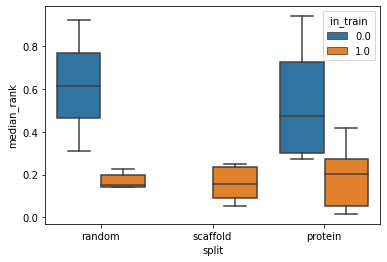

In [27]:
import seaborn as sns
sns.boxplot(data=median_ranks, x='split', y='median_rank', hue='in_train')